# Logistic regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, make_scorer


from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC



import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

# import custom functions
from src.functions import plot_correlations, plot_mutual_info, hello
from src.datasets import xy_train, xy_train_test, data_original, data_50000, data_balanced


def data_time730(dataset = data_original(), drop_censored = False):
    """ 
    replaces feature "time" with 
    - time730: counts the days over the 2 years time target 
    - time_censored: counts the censored days up to the 2 years time target
    """

    if "time" not in df.columns:
      print("Warning: the data does not have a feature 'time' to be replaced with time730.")
      return df

    # this shifted ReLU does the job:
    df["time730"] = np.maximum(0, df['time'] - 730)

    # censored patients: they quit the study before 2 years
    if not drop_censored:
      df["time_censored"] = np.maximum(0,730 - df['time'])

    df= df.drop(columns = ['time'])
    return df

## 042 Data preprocessing and oversampling

### Load dataset

In [2]:
data = datasets.data_original()

### Feature engineering 

In [3]:
data = features.engineer(data)

### Train test split (unprocessed)

In [4]:
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Oversampling train data 

In [5]:
# identify categorical features 
# The dataset does not have categorical features with more than 4 categories
cat_features = [c for c in X_train_.columns if X_train_[c].nunique() < 5]

In [6]:
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
X_oversampled, y_oversampled = smote_nc.fit_resample(X_train_, y_train_) 

### Scaling the data 

In [68]:
scaler = StandardScaler()

scaler.fit(X_train_)

X_train_scaled_oversampled = scaler.transform(X_oversampled)
X_test_scaled = scaler.transform(X_test_)

### Data ready for Machine Learning

In [69]:
X_train =pd.DataFrame(X_train_scaled_oversampled,columns=X_.columns)
X_test =pd.DataFrame(X_test_scaled,columns=X_.columns)
y_train =y_oversampled 
y_test = y_test_ 

## 042-Sprint2 feature selection for oversampled data

In [70]:

def cv_mean_scores(Xtrain, ytrain, model = LogisticRegression(random_state=42), n_splits  = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
     
    # Choose the scores to be computed
    selectivity_score = make_scorer(recall_score, pos_label = 0)

    f3_score = make_scorer(fbeta_score,beta = 3)

    my_scores= {
        "accuracy": "accuracy",
        "f3": f3_score,
        "recall": "recall",
        "selectivity": selectivity_score, 
        "precision": "precision",
        "f1": "f1"
    }

    # Perform cross-validation measuring the scores
    cv_results = cross_validate(
        model, Xtrain, ytrain, cv=cv, n_jobs=-1, scoring= my_scores
    )


    # Calculate the mean of each score
    mean_scores =  {score : cv_results["test_"+score].mean() for score in my_scores}
    return mean_scores



### 042-043 Cross-validation for RFE 

In [71]:
def rfe_kfold_cv(X, y, max_k=None, cv=5, verbose = False):
    if max_k is None:
        max_k = X.shape[1]
    
    results_rfe_kfold_cv = []
    for k in range(1, max_k + 1):
        
        
        rfe = RFE(estimator=LogisticRegression(solver="newton-cg",random_state=42), n_features_to_select=k)
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_]
        
        model = LogisticRegression(solver="newton-cg", random_state=42)
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        cv_scores = cv_mean_scores(X[selected_features], y, model)
        
        cv_scores["k"] = k
        cv_scores["features"] = list(selected_features)

        results_rfe_kfold_cv.append( cv_scores)

        if verbose:
            print(k)
            print(pd.DataFrame(cv_scores))
    
    return pd.DataFrame(results_rfe_kfold_cv).set_index('k')

In [72]:
results_rfe_kfold_cv = rfe_kfold_cv(X_train,y_train,cv=5)


In [73]:
print(results_rfe_kfold_cv)


    accuracy        f3    recall  selectivity  precision        f1  \
k                                                                    
1   0.846198  0.851311  0.852378     0.839999   0.842696  0.847268   
2   0.867834  0.893226  0.898749     0.836922   0.846566  0.871833   
3   0.882903  0.902242  0.906477     0.859334   0.866108  0.885754   
4   0.889474  0.904681  0.908027     0.870932   0.875809  0.891579   
5   0.892565  0.905868  0.908797     0.876337   0.880439  0.894364   
6   0.896042  0.906476  0.908791     0.883302   0.886236  0.897350   
7   0.901067  0.912450  0.914989     0.887160   0.890439  0.902484   
8   0.899910  0.912234  0.914983     0.884846   0.888301  0.901420   
9   0.904157  0.918038  0.921158     0.887160   0.890939  0.905780   
10  0.904158  0.914894  0.917297     0.891024   0.893929  0.905431   
11  0.906479  0.914038  0.915752     0.897202   0.899136  0.907301   
12  0.905706  0.913907  0.915755     0.895657   0.897803  0.906633   
13  0.903774  0.9135

In [74]:
for rfe_features in results_rfe_kfold_cv['features']:
    print(rfe_features)


['time730']
['offtrt', 'time730']
['offtrt', 'cd420', 'time730']
['race', 'offtrt', 'cd420', 'time730']
['hemo', 'race', 'offtrt', 'cd420', 'time730']
['hemo', 'drugs', 'race', 'offtrt', 'cd420', 'time730']
['hemo', 'drugs', 'z30', 'race', 'offtrt', 'cd420', 'time730']
['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730']
['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored']
['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored', 'trt1']
['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored', 'trt1', 'trt2']
['hemo', 'drugs', 'z30', 'race', 'gender', 'str2', 'offtrt', 'cd420', 'time730', 'time_censored', 'trt1', 'trt2']
['hemo', 'drugs', 'z30', 'preanti', 'race', 'gender', 'str2', 'offtrt', 'cd420', 'time730', 'time_censored', 'trt1', 'trt2']
['hemo', 'drugs', 'z30', 'preanti', 'race', 'gender', 'str2', 'offtrt', 'cd420', 'cd80', 'time730', 'time_censored', 'trt1',

### 042-045 Visualize Cross-validation scores 

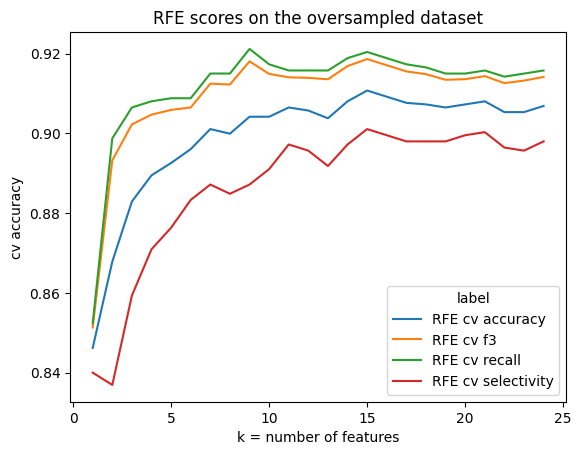

In [75]:
results_by_score = {}
for score in ["accuracy", "f3", "recall", "selectivity"]:
    results_by_score[score] = results_rfe_kfold_cv.copy()
    results_by_score[score]['label'] = "RFE cv " + score
    results_by_score[score]["score"] = results_rfe_kfold_cv[score]


results_all = pd.concat(results_by_score.values())

sns.lineplot(data = results_all, x = "k", y = "score", hue="label")
plt.ylabel("cv accuracy")
plt.xlabel("k = number of features")
plt.title("RFE scores on the oversampled dataset")
plt.show()

## 046 Choose best models 

Here we choose the best models selected with both the RFE algorithm.

In [76]:
k_rfe = 9
rfe_selected_features=results_rfe_kfold_cv.loc[k_rfe,"features"]

k_skb = 4
skb_selected_features=results_rfe_kfold_cv.loc[k_skb,"features"]

print(f"selected features for performance:",k_rfe, rfe_selected_features) 
print(f"\nselected features for simplicity:",k_skb, skb_selected_features) 

selected features for performance: 9 ['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored']

selected features for simplicity: 4 ['race', 'offtrt', 'cd420', 'time730']


Now we fit the best models

In [77]:
model_rfe = LogisticRegression(random_state=42) 
X_rfe_train = X_train[rfe_selected_features]
X_rfe_test = X_test[rfe_selected_features]
model_rfe.fit(X_rfe_train,y_train)

LogisticRegression(random_state=42)

In [78]:
model_skb = LogisticRegression(random_state=42) 
X_skb_train = X_train[skb_selected_features]
X_skb_test = X_test[skb_selected_features]
model_skb.fit(X_skb_train,y_train)

LogisticRegression(random_state=42)

## 047 Discuss model performance

In [79]:
f3_score = make_scorer(fbeta_score, beta = 3)

In [80]:
from sklearn.model_selection import cross_validate 
def cv_mean_scores(Xtrain, ytrain, model = LogisticRegression(random_state=42), n_splits  = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
     
    # Choose the scores to be computed
    selectivity_score = make_scorer(recall_score, pos_label = 0)
    negative_predictive_value = make_scorer(precision_score, pos_label = 0)


    my_scores= {
        "accuracy": "accuracy",
        "recall": "recall",   # true positive rate
        "selectivity": selectivity_score,   # true negative rate
        "precision": "precision",  # positive predictive value 
        "NPV": negative_predictive_value, # negative predictive value,
        "f1": "f1",
        "f3": f3_score,
        "ROC_AUC": "roc_auc"
    }

    # Perform cross-validation measuring the scores
    cv_results = cross_validate(
        model, Xtrain, ytrain, cv=cv, n_jobs=-1, scoring= my_scores
    )


    # Calculate the mean of each score
    mean_scores =  {score : cv_results["test_"+score].mean() for score in my_scores}
    return mean_scores

We evaluate the best SKB model

In [81]:
best_skb_cv_scores = cv_mean_scores(X_skb_train,y_train)
for score in best_skb_cv_scores:
    print(score, ":", f"{best_skb_cv_scores[score]:.3f}") 

accuracy : 0.889
recall : 0.908
selectivity : 0.871
precision : 0.876
NPV : 0.904
f1 : 0.892
f3 : 0.905
ROC_AUC : 0.956


In [82]:
best_rfe_cv_scores = cv_mean_scores(X_rfe_train,y_train)
for score in best_rfe_cv_scores:
    print(score, ":", f"{best_rfe_cv_scores[score]:.3f}") 

accuracy : 0.904
recall : 0.921
selectivity : 0.887
precision : 0.891
NPV : 0.918
f1 : 0.906
f3 : 0.918
ROC_AUC : 0.962


The model has no obvious weaknesses and it is very good on Recall (true positive rate), which is actually what we care about the most. 
In cross-validation, if a patient is truly "infected" then the model classifies the patient correctly 92% of the times, on cv_average. 

**Caveat** We are doing cross validation on a train set in which the target class "infected" has been oversampled. For this reason the score "Recall" may be too optimistic.

## 048 Interpret model coefficients 

In [83]:
# model intercept:

intercept_rfe = model_rfe.intercept_[0]
intercept_skb = model_skb.intercept_[0]


print(f"The intercept of the best SKB model is equal to {intercept_skb:.4f}")
print(f"The intercept of the best RFE model is equal to {intercept_rfe:.4f}")

The intercept of the best SKB model is equal to -1.6209
The intercept of the best RFE model is equal to -1.8831


The intercept is negative. It means that an average patient is evaluated by the models with a bias. This bias is towards the "non-infected" class. 

In [84]:
# we calculate the model coefficients for each feature 

coefficients_skb = pd.DataFrame({
    "feature": skb_selected_features,
    "coefficient": model_skb.coef_[0]
})

coefficients_rfe = pd.DataFrame({
    "feature": rfe_selected_features,
    "coefficient": model_rfe.coef_[0]
})

coefficients_rfe.sort_values(by="coefficient", inplace=True)
coefficients_skb.sort_values(by="coefficient", inplace=True)


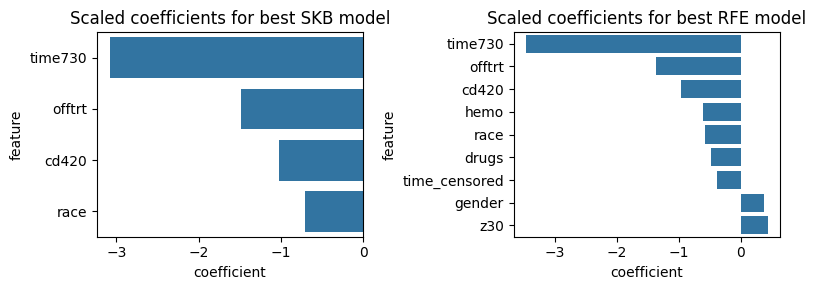

In [85]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

sns.barplot(data = coefficients_skb, y = "feature", x = "coefficient", ax = axes[0])
sns.barplot(data = coefficients_rfe, y = "feature", x = "coefficient", ax = axes[1])

axes[0].set_title("Scaled coefficients for best SKB model")
axes[1].set_title("Scaled coefficients for best RFE model")

plt.tight_layout()
plt.show()

## 049 Render coefficients insights 

### 049-a Obtain coefficients for the unscaled variables

The coefficients found in 048 are relative to the features scaled with StandardScaler. They are therefore hard to interpret as they are. 
We now calculate the coefficients one gets for the un-scaled regressors. 

In [86]:
# for each variable we calculate the rate of scaling 
scaling_factors = pd.DataFrame({
    "feature": X_.columns,
    "scaling_factor": scaler.scale_
})
scaling_factors.head(3)

,feature,scaling_factor
0,age,8.676423
1,wtkg,13.182555
2,hemo,0.274985


In [87]:
# we merge with model coefficients 
coefficients_and_scaling_skb = coefficients_skb.merge(scaling_factors)
coefficients_and_scaling_rfe = coefficients_rfe.merge(scaling_factors)

# calculate un-scaled coefficient
coefficients_and_scaling_skb["coefficient_unscaled"] = coefficients_and_scaling_skb["coefficient"] / coefficients_and_scaling_skb["scaling_factor"]
coefficients_and_scaling_rfe["coefficient_unscaled"] = coefficients_and_scaling_rfe["coefficient"] / coefficients_and_scaling_rfe["scaling_factor"]

# order and print the results
coefficients_and_scaling_skb.sort_values(by="coefficient", ascending=False, inplace=True)
coefficients_and_scaling_rfe.sort_values(by="coefficient", ascending=False, inplace=True)

print("Feature coefficients of the model selected by SKB:")
print(coefficients_and_scaling_skb)
print()
print("Feature coefficients of the model selected by RFE:")
print(coefficients_and_scaling_skb)



Feature coefficients of the model selected by SKB:
   feature  coefficient  scaling_factor  coefficient_unscaled
3     race    -0.714222        0.452621             -1.577970
2    cd420    -1.023867      146.104521             -0.007008
1   offtrt    -1.491194        0.479664             -3.108829
0  time730    -3.084019      160.579635             -0.019206

Feature coefficients of the model selected by RFE:
   feature  coefficient  scaling_factor  coefficient_unscaled
3     race    -0.714222        0.452621             -1.577970
2    cd420    -1.023867      146.104521             -0.007008
1   offtrt    -1.491194        0.479664             -3.108829
0  time730    -3.084019      160.579635             -0.019206


### 049-b Model coefficients separately for binary vs continuous features

The log-odd contribution of our categorical variables is binary. The contribution of continuous features is proportional to their value. 
It is best to interpret the two types of variables separately. 

In [88]:
# we filter the categorical (binary) features 
binary_skb_mask = coefficients_and_scaling_skb['feature'].isin(cat_features)
binary_rfe_mask = coefficients_and_scaling_rfe['feature'].isin(cat_features)

coefficients_unscaled_skb_binary = coefficients_and_scaling_skb[binary_skb_mask].drop(columns = ["coefficient","scaling_factor"])
coefficients_unscaled_rfe_binary = coefficients_and_scaling_rfe[binary_rfe_mask].drop(columns = ["coefficient","scaling_factor"])

coefficients_unscaled_skb_continuous = coefficients_and_scaling_skb[~binary_skb_mask].drop(columns = ["coefficient","scaling_factor"])
coefficients_unscaled_rfe_continuous = coefficients_and_scaling_rfe[~binary_rfe_mask].drop(columns = ["coefficient","scaling_factor"])

# print for example
coefficients_unscaled_skb_binary


,feature,coefficient_unscaled
3,race,-1.577970
1,offtrt,-3.108829


To better understand and compare the variables and coefficients we further custom-rescale the continuous variables.

In [89]:
# custom scale continuous features 

for coefficients_unscaled in [coefficients_unscaled_skb_continuous, coefficients_unscaled_rfe_continuous]:

    # - time730, time_censored : unit = month (scale 30)
    time_features_mask = coefficients_unscaled["feature"].isin(["time730","time_censored"])

    coefficients_unscaled.loc[time_features_mask, "feature"] += " (months)"
    coefficients_unscaled.loc[time_features_mask, "coefficient_unscaled"] *= 30

    # - cd40, cd420 : unit = hundreds (scale 100)
    lab_features_mask = coefficients_unscaled["feature"].isin(["cd40","cd420"])

    coefficients_unscaled.loc[lab_features_mask, "feature"] += " (x100)"
    coefficients_unscaled.loc[lab_features_mask, "coefficient_unscaled"] *= 100

print("Unscaled coefficients for SKB model")
print(coefficients_unscaled_skb_continuous)
print()
print("Unscaled coefficients for RFE model")
print(coefficients_unscaled_rfe_continuous)


Unscaled coefficients for SKB model
            feature  coefficient_unscaled
2      cd420 (x100)             -0.700777
0  time730 (months)             -0.576166

Unscaled coefficients for RFE model
                  feature  coefficient_unscaled
6  time_censored (months)             -0.071461
2            cd420 (x100)             -0.659762
0        time730 (months)             -0.647585


### 049-c Visualize coefficients of unscaled variables

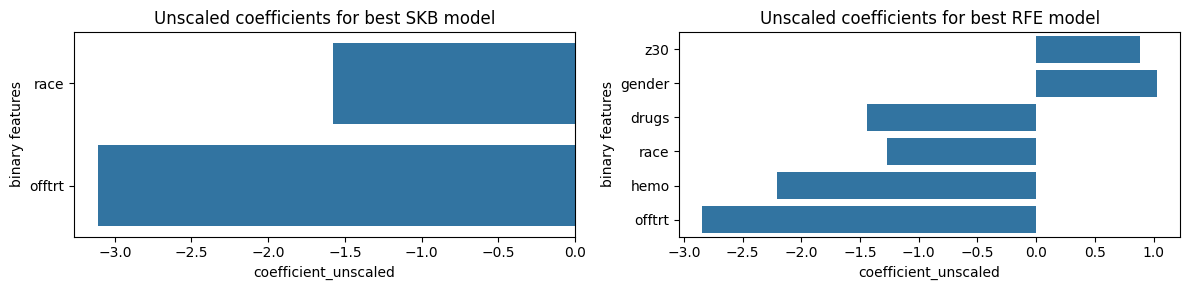

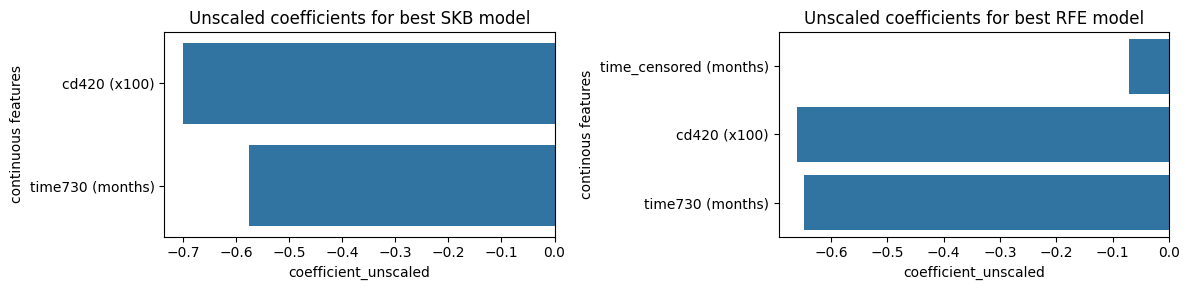

In [90]:
# Plot coefficients of binary features 
fig, axes = plt.subplots(1,2, figsize = (12,3))

sns.barplot(data = coefficients_unscaled_skb_binary, y = "feature", x = "coefficient_unscaled", ax = axes[0])
sns.barplot(data = coefficients_unscaled_rfe_binary, y = "feature", x = "coefficient_unscaled", ax = axes[1])

axes[0].set_title("Unscaled coefficients for best SKB model")
axes[1].set_title("Unscaled coefficients for best RFE model")

axes[0].set_ylabel("binary features")
axes[1].set_ylabel("binary features")
plt.tight_layout()
plt.show()

# Plot coefficients of continuous features
fig, axes = plt.subplots(1,2, figsize = (12,3))

sns.barplot(data = coefficients_unscaled_skb_continuous, y = "feature", x = "coefficient_unscaled", ax = axes[0])
sns.barplot(data = coefficients_unscaled_rfe_continuous, y = "feature", x = "coefficient_unscaled", ax = axes[1])

axes[0].set_title("Unscaled coefficients for best SKB model")
axes[1].set_title("Unscaled coefficients for best RFE model")

axes[0].set_ylabel("continuous features")
axes[1].set_ylabel("continous features")

plt.tight_layout()
plt.show()

## 050 + 052 Test set performance 

### Test performance with RFE

In [91]:
y_pred_rfe = model_rfe.predict(X_rfe_test)

In [92]:
results_test_rfe = {
    "accuracy": accuracy_score(y_test,y_pred_rfe),
    "recall": recall_score(y_test,y_pred_rfe),
    "selectivity": recall_score(y_test,y_pred_rfe,pos_label = 0),
    "precision": precision_score(y_test,y_pred_rfe),
    "NPV": precision_score(y_test,y_pred_rfe, pos_label = 0),
    "f1": f1_score(y_test,y_pred_rfe),
    "f3": fbeta_score(y_test,y_pred_rfe,beta = 3)
}

results_test_rfe

{'accuracy': 0.8948598130841121,
 'recall': np.float64(0.8076923076923077),
 'selectivity': np.float64(0.9228395061728395),
 'precision': np.float64(0.7706422018348624),
 'NPV': np.float64(0.9373040752351097),
 'f1': np.float64(0.7887323943661971),
 'f3': np.float64(0.8038277511961722)}

The recall score has dropped. The reason is clear: in cross-validation we used over-sampling. It would be better to oversample as part of the model. 

### Test performance with SKB

In [93]:
y_pred_skb = model_skb.predict(X_skb_test)

In [94]:
results_test_skb = {
    "accuracy": accuracy_score(y_test,y_pred_skb),
    "recall": recall_score(y_test,y_pred_skb),
    "selectivity": recall_score(y_test,y_pred_skb,pos_label = 0),
    "precision": precision_score(y_test,y_pred_skb),
    "NPV": precision_score(y_test,y_pred_skb, pos_label = 0),
    "f1": f1_score(y_test,y_pred_skb),
    "f3": fbeta_score(y_test,y_pred_rfe,beta = 3)

}

results_test_skb

{'accuracy': 0.8621495327102804,
 'recall': np.float64(0.8173076923076923),
 'selectivity': np.float64(0.8765432098765432),
 'precision': np.float64(0.68),
 'NPV': np.float64(0.9372937293729373),
 'f1': np.float64(0.74235807860262),
 'f3': np.float64(0.8038277511961722)}

Interestingly, the recall is higher than the selectivity with this model. It would be interesting to know which features do help to increase the recall score.


In [95]:
print(rfe_selected_features)
print(skb_selected_features)

['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored']
['race', 'offtrt', 'cd420', 'time730']


## 051 Confusion matrix 


In [96]:
cm_rfe  = confusion_matrix(y_test,y_pred_rfe)
cm_skb  = confusion_matrix(y_test,y_pred_skb)

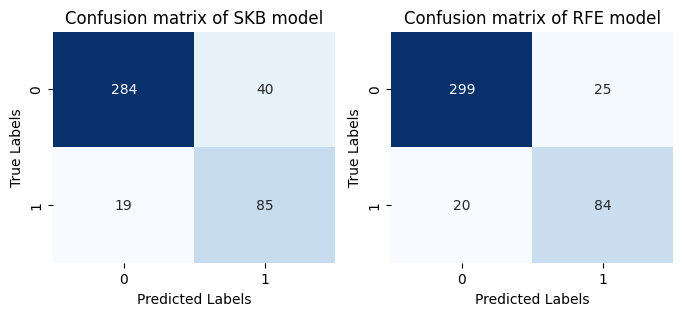

In [97]:
fig,ax = plt.subplots(1,2,figsize = (8,3))

sns.heatmap(cm_skb, annot=True, fmt='d', cmap='Blues', cbar=False, ax = ax[0])
sns.heatmap(cm_rfe, annot=True, fmt='d', cmap='Blues', cbar=False, ax = ax[1])

ax[0].set_title("Confusion matrix of SKB model")
ax[1].set_title("Confusion matrix of RFE model")
for i in [0,1]:
    ax[i].set_xlabel("Predicted Labels")
    ax[i].set_ylabel("True Labels")

plt.show()

In [98]:
cm_rfe [0]

array([299,  25])

In [99]:

num_test = [int(sum(cm_rfe[0])),int(sum(cm_rfe[1]))]
num_test

[324, 104]

## 053 Visualize confusion matrix data

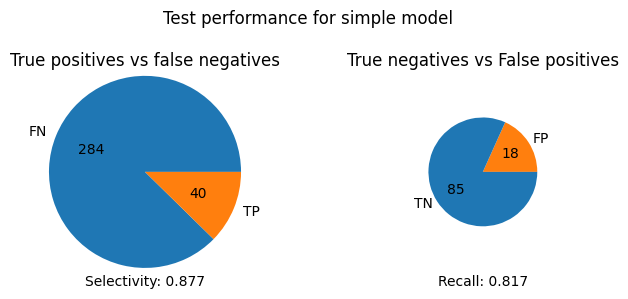

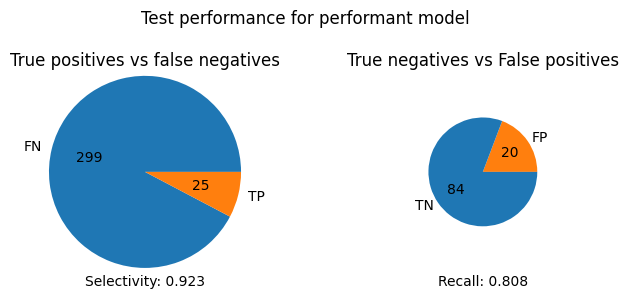

In [100]:
fig,ax = plt.subplots(1,2,figsize = (7,3))

# true infected vs true not infected test data count
num_test = [int(sum(cm_skb[0])),int(sum(cm_skb[1]))]


ax[0].set_title("True positives vs false negatives")
ax[1].set_title("True negatives vs False positives")
labels_pie = [["FN", "TP"],["FP", "TN"]]

for i in [0,1]:
    ax[i].pie(cm_skb[i], 
        labels = labels_pie[i], 
        colors = [sns.color_palette()[i], sns.color_palette()[1-i]], 
        radius = np.sqrt(2*num_test[i] / (num_test[0] + num_test[1])),
        autopct= lambda p: f'{int(num_test[i] * p / 100 )}') # to compute the count instead of the percentage
    
ax[0].set_xlabel(f"Selectivity: {results_test_skb["selectivity"]:.3f}")
ax[1].set_xlabel(f"Recall: {results_test_skb["recall"]:.3f}")
fig.suptitle("Test performance for simple model")
plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,2,figsize = (7,3))

# true infected vs true not infected test data count
num_test = [int(sum(cm_rfe[0])),int(sum(cm_rfe[1]))]


ax[0].set_title("True positives vs false negatives")
ax[1].set_title("True negatives vs False positives")
labels_pie = [["FN", "TP"],["FP", "TN"]]

for i in [0,1]:
    ax[i].pie(cm_rfe[i], 
        labels = labels_pie[i], 
        colors = [sns.color_palette()[i], sns.color_palette()[1-i]], 
        radius = np.sqrt(2*num_test[i] / (num_test[0] + num_test[1])),
        autopct= lambda p: f'{int(num_test[i] * p / 100 )}') # to compute the count instead of the percentage
    
ax[0].set_xlabel(f"Selectivity: {results_test_rfe["selectivity"]:.3f}")
ax[1].set_xlabel(f"Recall: {results_test_rfe["recall"]:.3f}")
fig.suptitle("Test performance for performant model")


plt.tight_layout()
plt.show()



## Save Logistic Regression Model

In [101]:
import pickle

In [105]:
# Save model to file
model = model_rfe
filename = "models/logistic_RFE9.pkl"
file = open(filename, "wb")
pickle.dump(model, file)

# The wb indicates that the file is opened for writing in binary mode.




We also save to file the features

In [103]:
pickle.dump(results_rfe_kfold_cv['features'], open("models/rfe_features_250103.pkl", "wb"))